## Debugging the `LabelModel` with deps + higher-order cliques

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath

from synthetic.generate import SingleTaskTreeDepsGenerator
from metal.label_model import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

### Generating a dataset

In [77]:
# Generate synthetic dataset
np.random.seed(2)
N = 10000
M = 10
K = 2
EDGE_PROB=0.5
data = SingleTaskTreeDepsGenerator(N, M, k=K, edge_prob=EDGE_PROB)

### Training the `LabelModel`

Note that:
* The `train` method assembles other data structures, such as the dependencies junction tree, etc.
* The `higher_order_cliques` kwarg controls whether or not to include them

In [109]:
lm = LabelModel(k=data.k, class_balance=data.p)

In [110]:
lm.config['higher_order_cliques'] = True

In [111]:
# Generate the "correct" mu
lm._set_constants(data.L)
lm._set_dependencies(data.E)
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)

# Compute O, O_inv, P based on L
lm._generate_O(data.L.todense())
O = lm.O.numpy()
d, d = O.shape
O_inv = np.linalg.inv(O)
P = np.diag(data.p)

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T

In [112]:
# Check that JJT is indeed PSD ==> ZZT is rank k
np.linalg.eig(JJT)[0]

array([226.72624551,   0.48127795])

In [113]:
np.linalg.eig(ZZT)[0]

array([ 8.22617521e+02+0.00000000e+00j,  7.32978108e+00+0.00000000e+00j,
        2.65282897e-12+2.67803693e-12j,  2.65282897e-12-2.67803693e-12j,
       -2.43008102e-12+1.11554926e-12j, -2.43008102e-12-1.11554926e-12j,
       -1.80948540e-12+1.68601411e-12j, -1.80948540e-12-1.68601411e-12j,
        1.99482798e-12+0.00000000e+00j, -5.02201306e-13+1.70732221e-12j,
       -5.02201306e-13-1.70732221e-12j,  9.31663951e-13+1.06064510e-12j,
        9.31663951e-13-1.06064510e-12j,  1.36892460e-12+0.00000000e+00j,
        9.13282683e-13+0.00000000e+00j,  1.76917587e-13+7.30585141e-13j,
        1.76917587e-13-7.30585141e-13j,  7.17208837e-13+0.00000000e+00j,
       -4.97192895e-13+0.00000000e+00j,  3.25417080e-13+2.56992490e-13j,
        3.25417080e-13-2.56992490e-13j, -3.76387102e-13+0.00000000e+00j,
       -9.04462758e-14+3.04176385e-13j, -9.04462758e-14-3.04176385e-13j,
       -2.76277049e-13+1.29938792e-13j, -2.76277049e-13-1.29938792e-13j,
        3.94448282e-14+2.57715953e-13j,  3.94448282

In [114]:
lm.train(
    data.L,
    deps=data.E,
    all_unary_cliques=True,
    higher_order_cliques=True,
    n_epochs=50000,
    print_every=5000,
    lr=0.0001,
    l2=0,
    O_inv_prec=1024,
    O_inv=ZZT
)

# Test against the true parameter values
mu_est = lm.mu.detach().numpy()
print(f"Average absolute error: {np.mean(np.abs(mu_est - mu))}")

Estimating Z...
[Epoch 0] Loss: 153778.453125
[Epoch 5000] Loss: 738.334656
[Epoch 10000] Loss: 689.848572
[Epoch 15000] Loss: 693.309753
[Epoch 20000] Loss: 695.126587
[Epoch 25000] Loss: 689.068909
[Epoch 30000] Loss: 696.690125
[Epoch 35000] Loss: 688.366638
[Epoch 40000] Loss: 692.323853
[Epoch 45000] Loss: 696.190002
[Epoch 49999] Loss: 687.513794
Estimating \mu...
[Epoch 0] Loss: 265.488739
[Epoch 5000] Loss: 0.164005
[Epoch 10000] Loss: 0.062804
[Epoch 15000] Loss: 0.016952
[Epoch 20000] Loss: 0.008290
[Epoch 25000] Loss: 0.005714
[Epoch 30000] Loss: 0.004230
[Epoch 35000] Loss: 0.003203
[Epoch 40000] Loss: 0.002462
[Epoch 45000] Loss: 0.001919
[Epoch 49999] Loss: 0.001517
Average absolute error: 0.06789893293756714


### Sanity check that the true $Z$ gets lower loss

In [90]:
sorted(np.linalg.eig(O)[0])[::-1]

[5.753829,
 0.9881643,
 0.79280466,
 0.5886363,
 0.42065313,
 0.39891785,
 0.319253,
 0.28811616,
 0.27188635,
 0.23557131,
 0.19738486,
 0.16879842,
 0.15442248,
 0.1098022,
 0.10037828,
 0.09432074,
 0.086093254,
 0.07948999,
 0.075762644,
 0.070650406,
 0.062205486,
 0.059156273,
 0.051424246,
 0.038241178,
 0.031588066,
 0.02197903,
 0.020935558,
 0.019912206,
 0.019411623,
 0.016787104,
 0.01423359,
 0.011719892,
 0.009382029,
 0.008537213,
 0.007338565,
 0.0063916175,
 0.005386561,
 0.0034077151,
 0.0026994958,
 0.0017272022]

In [ ]:
O = lm.O.numpy()
d, d = O.shape
O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()
P = lm.P.numpy()

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T

np.linalg.norm((O_inv + ZZT) * mask)**2

#### Seed=2

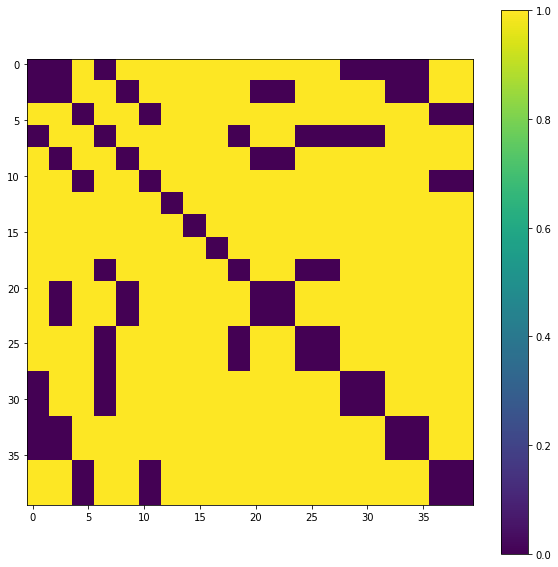

In [81]:
visualize_matrix(mask)

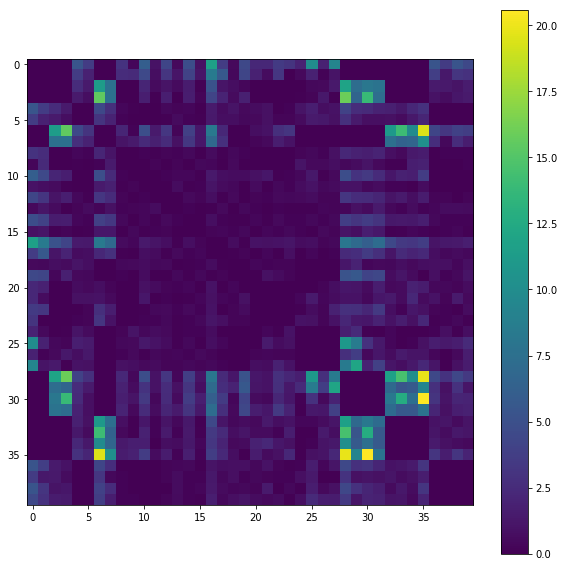

In [82]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [84]:
lm.c_data

{0: {'start_index': 0, 'end_index': 2, 'max_cliques': {3, 4}},
 1: {'start_index': 2, 'end_index': 4, 'max_cliques': {0, 4}},
 2: {'start_index': 4, 'end_index': 6, 'max_cliques': {5}},
 3: {'start_index': 6, 'end_index': 8, 'max_cliques': {2, 3}},
 4: {'start_index': 8, 'end_index': 10, 'max_cliques': {0}},
 5: {'start_index': 10, 'end_index': 12, 'max_cliques': {5}},
 6: {'start_index': 12, 'end_index': 14, 'max_cliques': {1}},
 7: {'start_index': 14, 'end_index': 16, 'max_cliques': {7}},
 8: {'start_index': 16, 'end_index': 18, 'max_cliques': {6}},
 9: {'start_index': 18, 'end_index': 20, 'max_cliques': {2}},
 (1, 4): {'start_index': 20, 'end_index': 24, 'max_cliques': {0}},
 (4, 1): {'start_index': 20, 'end_index': 24, 'max_cliques': {0}},
 (3, 9): {'start_index': 24, 'end_index': 28, 'max_cliques': {2}},
 (9, 3): {'start_index': 24, 'end_index': 28, 'max_cliques': {2}},
 (0, 3): {'start_index': 28, 'end_index': 32, 'max_cliques': {3}},
 (3, 0): {'start_index': 28, 'end_index': 32,

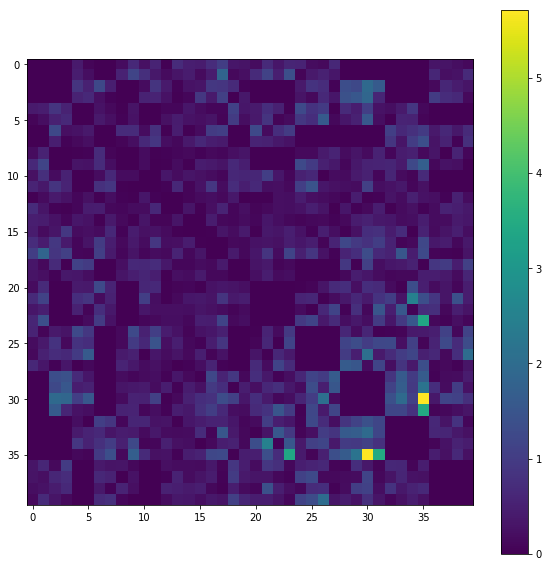

In [83]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=1

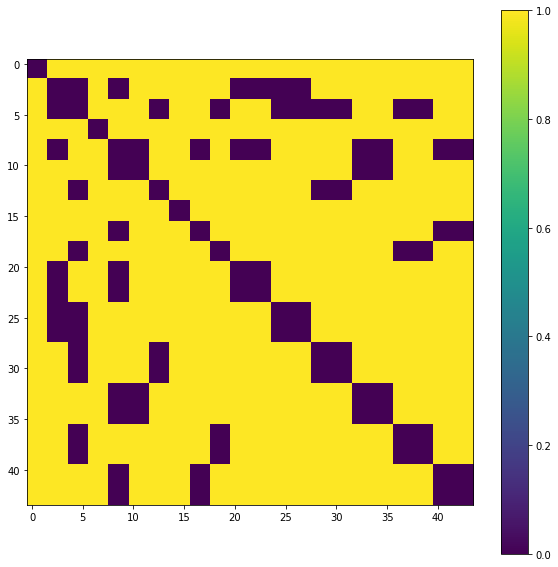

In [74]:
visualize_matrix(mask)

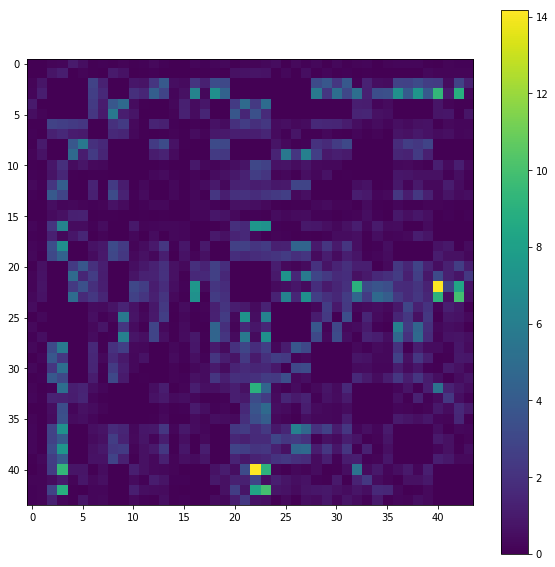

In [75]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

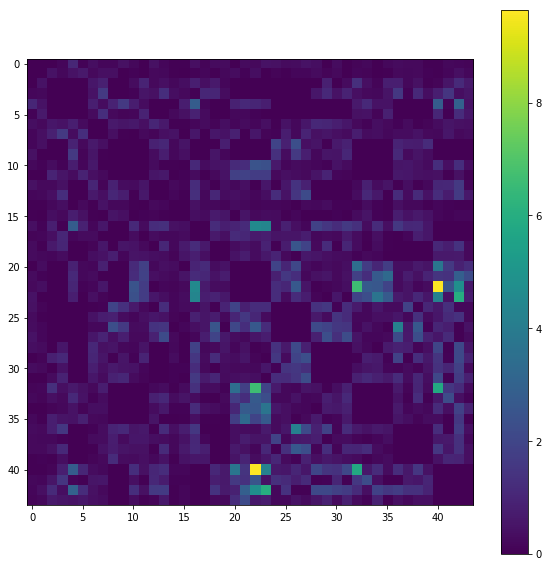

In [76]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=0

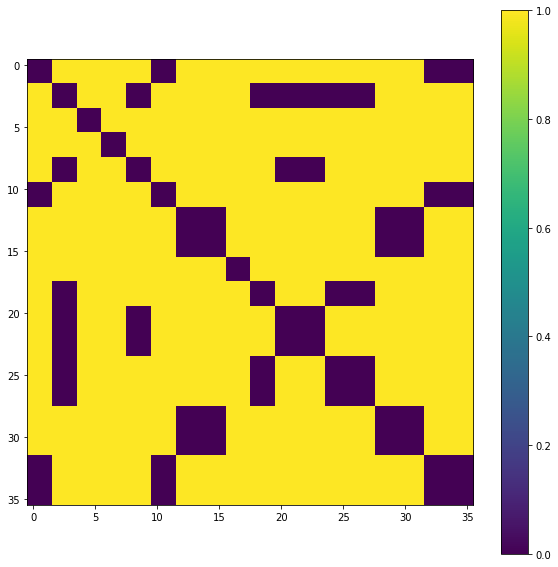

In [67]:
visualize_matrix(mask)

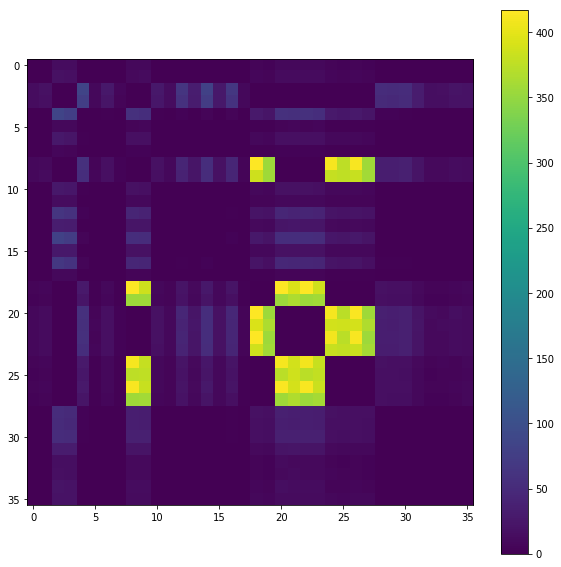

In [68]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

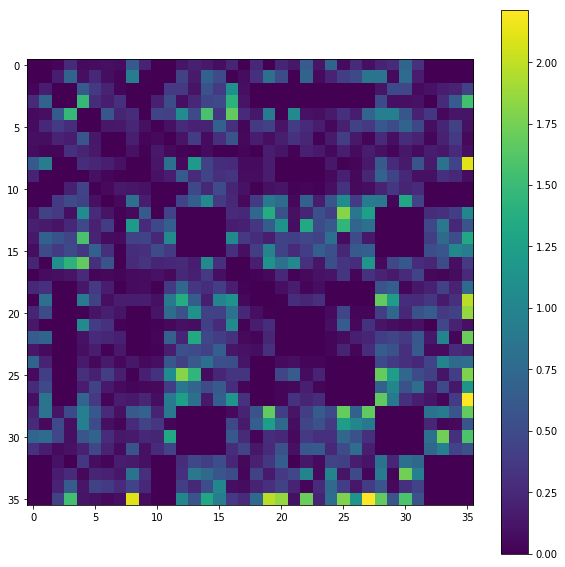

In [69]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

### Visualizing matrices

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
lm.c_data

In [ ]:
data.E

### Trying to solve with `scipy.optimize.minimize`

In [ ]:
from scipy.optimize import minimize

O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()

z0 = np.random.randn(lm.d * lm.k)

def objective_fn(z):
    Z = z.reshape(-1, data.k)
    return np.linalg.norm( (O_inv + Z @ Z.T) * mask )**2

def gradient_fn(z):
    Z = z.reshape(-1, data.k)
    X = (O_inv + Z @ Z.T) * mask
    return np.ravel(X @ Z)

res = minimize(objective_fn, z0, jac=gradient_fn, method='BFGS')
Z = res['x'].reshape(-1, data.k)
res['fun']

In [ ]:
O = lm.O.numpy()
P = lm.P.numpy()
I_k = np.eye(data.k)
Q = O @ Z @ np.linalg.inv(I_k + Z.T @ O @ Z) @ Z.T @ O

mu0 = np.random.randn(lm.d * lm.k)

def objective_fn_2(mu):
    M = mu.reshape(-1, data.k)
    return np.linalg.norm(Q - M @ P @ M.T)**2 + np.linalg.norm(np.sum(M @ P, 1) - np.diag(O))**2

res_2 = minimize(objective_fn_2, mu0, method='BFGS')
M = res_2['x'].reshape(-1, data.k)
res_2['fun']

In [ ]:
# Test against the true parameter values
print(f"Average absolute error: {np.mean(np.abs(M - mu))}")

## Visualizing the inverse covariance matrix

In [ ]:
J = compute_inv_covariance(
    lm._get_augmented_label_matrix(data.L.todense()),
    data.Y,
    data.k,
    data.p
)
visualize_matrix(np.abs(J))

In [ ]:
visualize_matrix(lm.mask.numpy(), fig_size=[5,5])

In [ ]:
O_inv = lm.O_inv.numpy()
Z = lm.Z.detach().numpy()
mask = lm.mask.numpy()
visualize_matrix(np.abs((O_inv + Z@Z.T) * mask))

### Looking at the internal 'bookkeeping' of cliques...

In [ ]:
lm.c_data

In [ ]:
# Dependency edge weights
[((i,j), data.theta[(i,j)]) for i,j in data.E]